# Los Angeles Airbnb Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob 
import gmplot 
import re
from datetime import datetime,date
from collections import defaultdict
import folium
import json
from folium.plugins import HeatMap
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os 

## Loading and Data Wrangling

The listing files for each month from January 2016 to December 2019 are scraped and stored in a folder.
Create a function clean_listing to load and clean all data:

In [2]:
file_names=[]
for name in glob.glob('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/listing*.csv'):
    file_names.append(os.path.basename(name))    

In [3]:
#'calculated_host_listings_count',
def clean_listing(filename):
    
    listing=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/'+filename)
    del_cols=['listing_url','scrape_id','experiences_offered','thumbnail_url','medium_url',
                          'picture_url','xl_picture_url','host_url','host_response_time','host_neighbourhood',
                          'host_response_rate','host_acceptance_rate','host_thumbnail_url',
                          'host_picture_url','host_verifications',
                          'calculated_host_listings_count_entire_homes','notes',
                          'calculated_host_listings_count_private_rooms',
                          'calculated_host_listings_count_shared_rooms',
                          'license','jurisdiction_names','square_feet',
                          'weekly_price','monthly_price','neighborhood_overview',
                          'transit','access','interaction','house_rules','space',
                          'host_about','host_name','neighbourhood','smart_location',
                          'minimum_minimum_nights', 'maximum_minimum_nights',
                          'minimum_maximum_nights', 'maximum_maximum_nights','calendar_updated',
                          'calendar_last_scraped','requires_license','minimum_nights_avg_ntm', 
                          'maximum_nights_avg_ntm','market','street','country_code','country','state',
                          'city','host_location','host_total_listings_count','zipcode',
                          'security_deposit','host_has_profile_pic','host_listings_count','description',
                          'name','summary','neighbourhood_group_cleansed','cancellation_policy']
    for col in (set(del_cols) & set(listing.columns)):
        listing = listing.drop([col], axis=1)

    #Remove listing with id=23043744, because it is an outlier discovered by visualization
    listing = listing[listing.id != 23043744]
    #Remove listing with incorrect reviews per month, first review, number of reviews columns
    listing = listing[listing.id != 507927]
    #correct the listing with 21 bedrooms
    listing.bedrooms[listing.id==39395189]=1
    #reviews per month
    listing.fillna({'reviews_per_month':0},inplace=True)
    #drop rows where the bathrooms, bedrooms and beds are NaN
    listing=listing.dropna(subset=['bedrooms', 'bathrooms','beds'])
    #date variable list:
    date_variables=['host_since','last_scraped','first_review','last_review']
    #price variable list:
    price_variables=['price','extra_people','cleaning_fee']
    #convert date variables into datetime object
    listing[date_variables]=listing[date_variables].apply(lambda x: x.astype(str))
    #pd.to_datetime(listing_20191205[date_variables], format='%Y-%m-%d')
    listing[date_variables]=listing[date_variables].apply(pd.to_datetime,format='%Y-%m-%d')
    #convert price column to numeric
    listing[price_variables]=listing[price_variables].apply(lambda x: x.astype(str).str.replace('$',''))
    listing[price_variables]=listing[price_variables].apply(lambda x: x.astype(str).str.replace(',',''))
    listing[price_variables]=listing[price_variables].apply(pd.to_numeric,errors='coerce', axis=1)
    
    #remove listings with zero price and limit the listing prices to be below 4000,
    #because the characteristics of the super luxurious listings and the regular listings are different
    #the 2000 threshold is determined after plotting the distribution of listing prices.
    listing=listing[listing.price!=0]
    listing=listing[listing.price<=2000]
    
    #convert binary columns to 0/1 values
    (listing[['require_guest_phone_verification','require_guest_profile_picture']]=='t').astype(int)
    (listing[['availability_30','availability_365','availability_60', 'availability_90','has_availability']]=='t').astype(int)
    (listing[['instant_bookable','is_location_exact']]=='t').astype(int)
    #(listing[['instant_bookable','is_business_travel_ready','is_location_exact']]=='t').astype(int)
    
    #impute empty reviews rows by means of the review category
    listing[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
             'review_scores_communication','review_scores_location','review_scores_value']] = listing[['review_scores_rating',
             'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
             'review_scores_location','review_scores_value']].apply(lambda x: x.fillna(x.mean()),axis=0)
    
    #create columns -review_sincefirst and review_sincelast
    listing['review_sincefirst']=listing.last_scraped-listing.first_review
    listing['review_sincefirst']=listing.review_sincefirst.fillna(pd.Timedelta(seconds=0))
    listing['review_sincelast']=listing.last_scraped-listing.last_review
    listing['review_sincelast']=listing.review_sincefirst.fillna(pd.Timedelta(seconds=0))
    listing['review_sincefirst']=listing['review_sincefirst'].apply(lambda x: str(x))
    listing['review_sincelast']=listing['review_sincelast'].apply(lambda x: str(x))
    listing=listing.drop(['first_review', 'last_review'], axis=1)
    
    listing['review_sincefirst']=listing['review_sincefirst'].apply(lambda x: int(x.split(' ')[0]))
    listing['review_sincelast']=listing['review_sincelast'].apply(lambda x: int(x.split(' ')[0]))
    
    #host data, create extra column to indicate if host information is present
    listing['host_info']=['f' if h is None else 't' for h in listing.host_since]
    listing.host_is_superhost[listing.host_is_superhost.isna()]='f'
    
    #create fee price ratio column, remove listings with the ratio greater than 2.
    #some listings has a minimum renting period of 30 days, and the first day price is set very low.
    listing['fee_price_ratio']=listing['cleaning_fee']/listing['price']
    listing=listing[listing['fee_price_ratio']<2]
    
    #create Year and Month columns
    listing['Year']=listing.last_scraped.dt.year
    listing['Month']=listing.last_scraped.dt.month
    
    #drop unnecessary columns
    listing=listing.drop(['last_scraped','fee_price_ratio'],axis=1)
    
    return listing

In [4]:
df_listing=[]
for fn in file_names:
    df_listing.append(clean_listing(fn))

In [5]:
df=pd.concat(df_listing)

In [6]:
listing_20191205=df[(df.Year==2019) & (df.Month==12)]
listing_20191205.head()

,Month,Year,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,review_sincefirst,review_sincelast,reviews_per_month,room_type
0,12,2019,6,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,248,0,0,2.0,Real Bed,...,6.000000,10.000000,8.000000,10.000000,80.000000,8.000000,3035,3035,0.02,Entire home/apt
1,12,2019,6,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,62,0,0,1.0,Real Bed,...,10.000000,10.000000,10.000000,10.000000,97.000000,10.000000,1270,1270,0.19,Entire home/apt
2,12,2019,1,"{Internet,Wifi,""Air conditioning"",""Wheelchair ...",12,252,38,38,1.5,Real Bed,...,10.000000,10.000000,10.000000,10.000000,98.000000,10.000000,2006,2006,0.33,Private room
3,12,2019,1,"{Internet,Wifi,Kitchen,Heating,Washer,Dryer,""S...",9,344,39,69,1.0,Pull-out Sofa,...,9.000000,9.000000,9.000000,10.000000,94.000000,9.000000,3105,3105,0.19,Private room
4,12,2019,2,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,0,0,0,1.0,Real Bed,...,9.752515,9.416879,9.731454,9.699355,94.333865,9.440493,0,0,0.00,Entire home/apt


In [7]:
listing_20191205.columns

Index(['Month', 'Year', 'accommodates', 'amenities', 'availability_30',
       'availability_365', 'availability_60', 'availability_90', 'bathrooms',
       'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count',
       'cleaning_fee', 'extra_people', 'guests_included', 'has_availability',
       'host_id', 'host_identity_verified', 'host_info', 'host_is_superhost',
       'host_since', 'id', 'instant_bookable', 'is_business_travel_ready',
       'is_location_exact', 'latitude', 'longitude', 'maximum_nights',
       'minimum_nights', 'neighbourhood_cleansed', 'number_of_reviews',
       'number_of_reviews_ltm', 'price', 'property_type',
       'require_guest_phone_verification', 'require_guest_profile_picture',
       'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value',
       'review_sincefirst', 'review_sincelast', 'reviews_per_mon

In [12]:
def clean_amenities(listing):
    amenities_count=defaultdict(int)

    for ind in range(len(listing_20191205)):
        am=listing_20191205.amenities
        for x in am.iloc[ind].split(','):
            x=x.replace('"','')
            x=x.replace('{','')
            x=x.replace('}','')
            x=x.replace('Cable TV','TV')
            x=x.replace('Internet','Wifi')
            if x not in amenities_count:
                amenities_count[x]=1
            else:
                amenities_count[x]+=1
    
    amenities_columns=pd.DataFrame(amenities_count.items(), columns=['Amenities','Count']).sort_values('Count',ascending=False)
    amenities_columns=amenities_columns.head(20).Amenities.to_list()
    
    for i in amenities_columns:
        listing[i]=listing['amenities'].apply(lambda x: 1 if i in x else 0)
    
    listing=listing.drop(['amenities'], axis=1)
    
    return listing

In [19]:
def clean_neighbourhood(listing):
    
    nh_top100=listing_20191205.groupby('neighbourhood_cleansed')['price'].count().sort_values(ascending=False).head(100).index.to_list()
    listing.neighbourhood_cleansed=['other area' if a not in nh_top100 else a for a in listing.neighbourhood_cleansed]
    nh_top100.append('other area')

    for i in nh_top100:
        listing[i]=listing['neighbourhood_cleansed'].apply(lambda x: 1 if x==i else 0)
    
    
    return listing

In [20]:
listing_201912=clean_amenities(listing_20191205)
listing_201912=clean_neighbourhood(listing_201912)
listing_201912.head()

,Month,Year,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,Boyle Heights,Northridge,Vermont Square,Glassell Park,Lawndale,Baldwin Hills/Crenshaw,Lake Balboa,Hyde Park,Carthay,View Park-Windsor Hills
0,12,2019,6,0,248,0,0,2.0,Real Bed,2.0,...,0,0,0,0,0,0,0,0,0,0
1,12,2019,6,0,62,0,0,1.0,Real Bed,3.0,...,0,0,0,0,0,0,0,0,0,0
2,12,2019,1,12,252,38,38,1.5,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0
3,12,2019,1,9,344,39,69,1.0,Pull-out Sofa,1.0,...,0,0,0,0,0,0,0,0,0,0
4,12,2019,2,0,0,0,0,1.0,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
listing_201912.to_csv (r'/Users/ruoqigao/Desktop/Springboard/capstone 1 data/l_201912.csv', index = None, header=True)

In [ ]:
#apply the cleaning steps to other dates

In [22]:
listing_201911=df[(df.Year==2019) & (df.Month==11)]

In [23]:
listing_201911=clean_amenities(listing_201911)
listing_201911=clean_neighbourhood(listing_201911)
listing_201911.head()

,Month,Year,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,Boyle Heights,Northridge,Vermont Square,Glassell Park,Lawndale,Baldwin Hills/Crenshaw,Lake Balboa,Hyde Park,Carthay,View Park-Windsor Hills
0,11,2019,6,0,214,0,0,2.0,Real Bed,2.0,...,0,0,0,0,0,0,0,0,0,0
1,11,2019,6,2,30,2,2,1.0,Real Bed,3.0,...,0,0,0,0,0,0,0,0,0,0
2,11,2019,1,0,309,4,34,1.5,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0
3,11,2019,1,0,310,5,35,1.0,Pull-out Sofa,1.0,...,0,0,0,0,0,0,0,0,0,0
4,11,2019,2,0,0,0,0,1.0,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
listing_201911.to_csv (r'/Users/ruoqigao/Desktop/Springboard/capstone 1 data/l_201911.csv', index = None, header=True)

In [31]:
listing_201901=df[(df.Year==2019) & (df.Month==1)]
listing_201901=clean_amenities(listing_201901)
listing_201901=clean_neighbourhood(listing_201901)
listing_201901.head()

,Month,Year,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,Boyle Heights,Northridge,Vermont Square,Glassell Park,Lawndale,Baldwin Hills/Crenshaw,Lake Balboa,Hyde Park,Carthay,View Park-Windsor Hills
0,1,2019,6,0,272,0,0,2.0,Real Bed,2.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2019,6,0,169,0,0,1.0,Real Bed,3.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2019,1,0,286,8,25,1.5,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,2019,1,30,365,60,90,1.0,Pull-out Sofa,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1,2019,2,0,0,0,0,1.0,Real Bed,1.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
listing_201901.to_csv (r'/Users/ruoqigao/Desktop/Springboard/capstone 1 data/l_201901.csv', index = None, header=True)

## Exploratory Analysis of the Reviews File

In [119]:
#only need to use the latest reviews file since it contains all the past reviews
reviews_20191205=pd.read_csv('/Users/ruoqigao/Desktop/Springboard/capstone 1 data/reviews_20191205.csv')

In [120]:
reviews_20191205.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


In [121]:
reviews_20191205.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [122]:
reviews_20191205.date=reviews_20191205.date.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [123]:
reviews_20191205.date.min()

Timestamp('2009-05-26 00:00:00')

In [124]:
#extract review data for a timespan of whole years
reviews_200920191205=reviews_20191205[reviews_20191205.date>'2009-12-05']
reviews_200920191205.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


In [125]:
reviews_count_month=defaultdict(int)
reviews_count_dayofweek=defaultdict(int)
for ind in reviews_200920191205.index:
    reviews_date=reviews_200920191205['date'][ind]
    reviews_count_month[reviews_date.month]+=int(1)
    reviews_count_dayofweek[reviews_date.weekday()]+=int(1)

In [126]:
print(reviews_count_month)

defaultdict(<class 'int'>, {8: 148398, 5: 117862, 6: 122754, 12: 72319, 3: 105398, 10: 137851, 7: 139317, 2: 83257, 1: 82716, 9: 134696, 4: 107471, 11: 116928})


In [127]:
print(reviews_count_dayofweek) #Monday is 0 and Sunday is 6

defaultdict(<class 'int'>, {0: 234393, 6: 288842, 1: 169494, 4: 180319, 5: 183252, 3: 155732, 2: 156935})


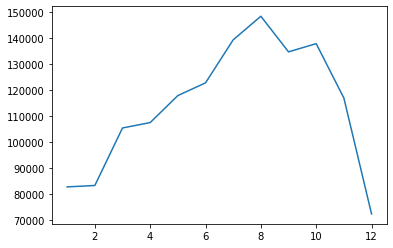

In [128]:
lists = sorted(reviews_count_month.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

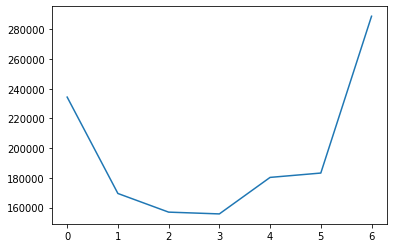

In [129]:
lists = sorted(reviews_count_dayofweek.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

## Data Visualization

In [15]:
#plot histogram of individual variables
def plot_hist(var,log = False):
    if log==False:
        listing_201912[var].plot(kind='hist',bins=10)
        ci=np.percentile(listing_201912[var],[2.5,97.5])
        mean=np.mean(listing_201912[var])
        plt.axvline(mean,color='k')
        plt.axvline(ci[0],color='k',linestyle='--')
        plt.axvline(ci[1],color='k',linestyle='--')
        plt.xlabel(var)
        plt.ylabel('frequency')
        plt.title('Distribution of '+ var)
    else:
        np.log(listing_201912[var]).plot(kind='hist',bins=10)
        ci=np.percentile(np.log(listing_201912[var]),[2.5,97.5])
        mean=np.mean(np.log(listing_201912[var]))
        plt.axvline(mean,color='k')
        plt.axvline(ci[0],color='k',linestyle='--')
        plt.axvline(ci[1],color='k',linestyle='--')
        plt.xlabel('log '+ var)
        plt.ylabel('frequency')
        plt.title('Distribution of '+ var)
    plt.show()
    

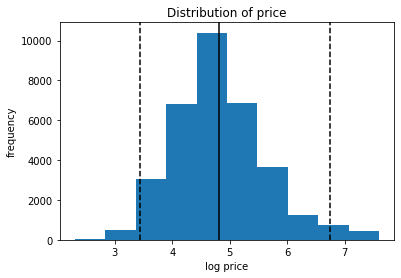

In [16]:
plot_hist('price',True)

In [17]:
def plot_ecdf(var):
    x=np.sort(listing_201912[var])
    y=np.arange(1,len(x)+1)/len(x)
    plt.plot(x,y,marker='.',linestyle='none')
    plt.show()

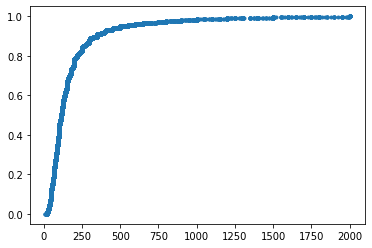

In [18]:
plot_ecdf('price')

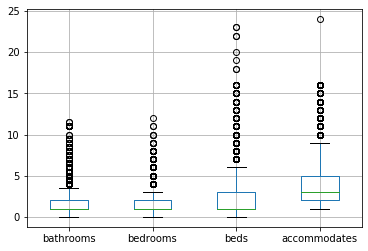

In [19]:
listing_201912.boxplot(column=['bathrooms', 'bedrooms', 'beds','accommodates'])

In [62]:
def plot_scatter(var1,var2,var3,cm):
    if cm=='v':
        listing_201912.plot.scatter(var1,var2,c=var3,colormap='viridis',figsize=(10,6.5))
    elif cm=='p':
        listing_201912.plot.scatter(var1,var2,c=var3,colormap=matplotlib.cm.get_cmap('Purples_r'),figsize=(10,6.5))
    elif cm=='m':
        listing_201912.plot.scatter(var1,var2,c=var3,colormap='plasma',figsize=(10,6.5))
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title('relationship between ' +var1+' and '+var2)
    plt.show()


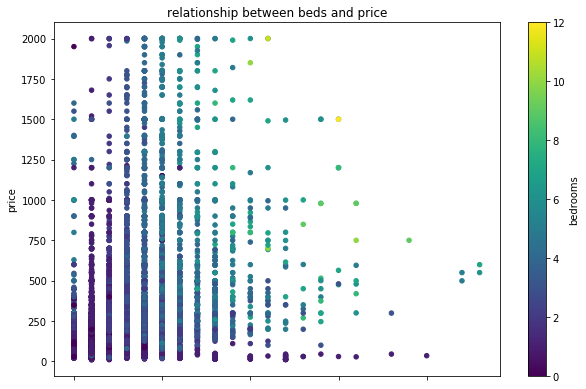

In [63]:
plot_scatter('beds','price','bedrooms','v')

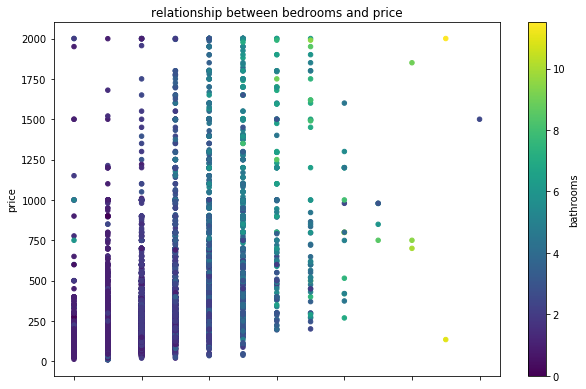

In [64]:
plot_scatter('bedrooms','price','bathrooms','v')

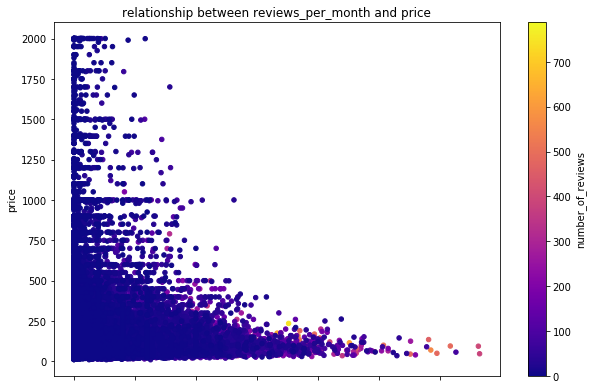

In [65]:
plot_scatter('reviews_per_month','price','number_of_reviews','m')

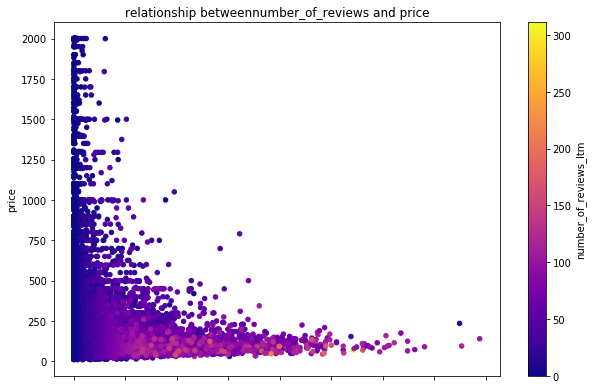

In [24]:
plot_scatter('number_of_reviews','price','number_of_reviews_ltm','m')

In [46]:
#number of reviews, number of reviews ltm-last twelve month
#plot_rw=sns.jointplot(x='number_of_reviews',y='number_of_reviews_ltm',data=listing_20191205)
#plt.show()

In [38]:
listing_201912.columns[60:90]

Index(['Dryer', 'Hot water', 'Free parking on premises', 'Refrigerator',
       'Fire extinguisher', 'Dishes and silverware', 'Venice', 'Hollywood',
       'Long Beach', 'Downtown', 'Santa Monica', 'Hollywood Hills',
       'West Hollywood', 'Westlake', 'Silver Lake', 'Mid-Wilshire',
       'Hollywood Hills West', 'Koreatown', 'Westwood', 'East Hollywood',
       'Glendale', 'Rowland Heights', 'Beverly Grove', 'Pasadena', 'Sawtelle',
       'Mid-City', 'Echo Park', 'Beverly Hills', 'North Hollywood',
       'Sherman Oaks'],
      dtype='object')

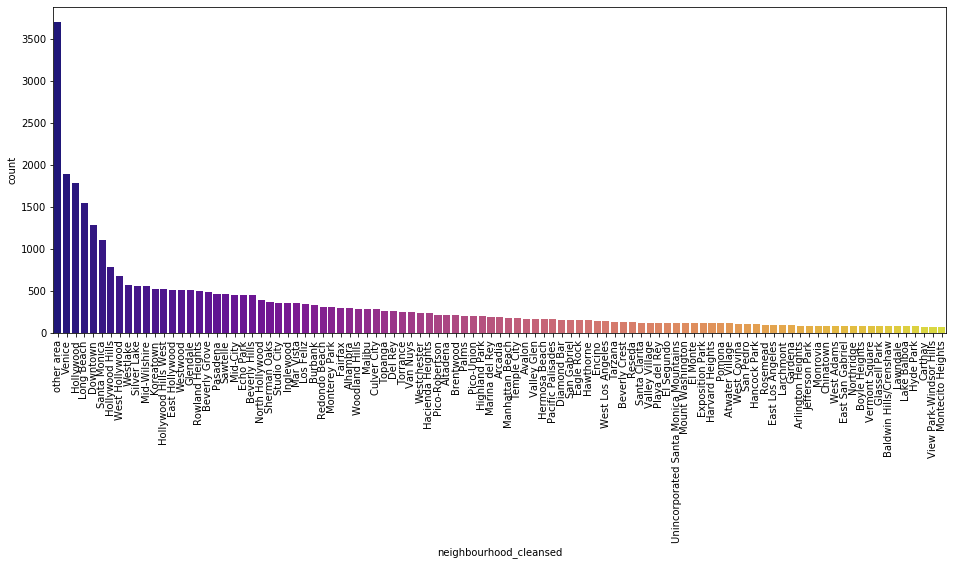

In [59]:
plt.figure(figsize=(16,6))
chart=sns.countplot(listing_201912['neighbourhood_cleansed'], palette="plasma",order = listing_201912['neighbourhood_cleansed'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90);

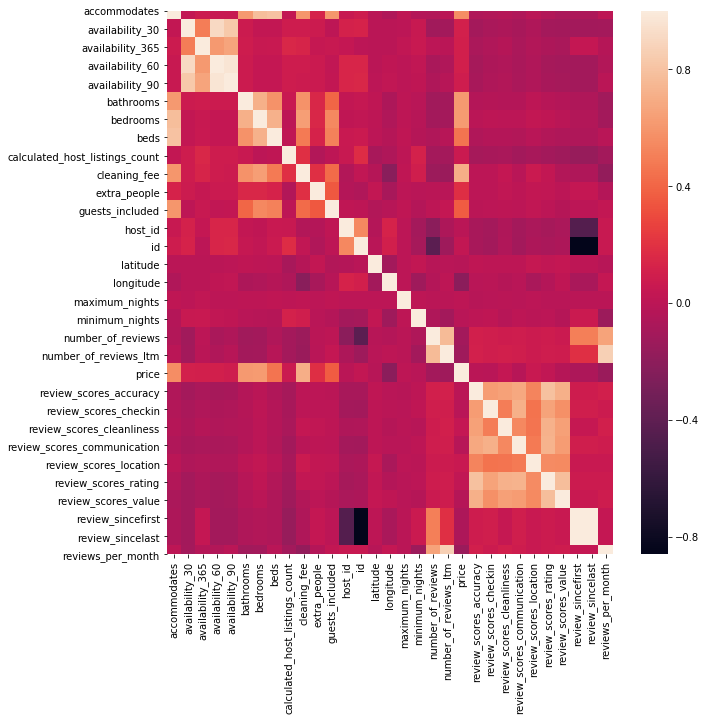

In [66]:
#corr matrix
rv_cor=listing_201912.iloc[:,2:47].corr(method ='pearson') 
plt.figure(figsize=(10,10))
sns.heatmap(rv_cor,annot=False)    

In [29]:
listing_201912.bed_type.value_counts()

Real Bed         33408
Futon              110
Pull-out Sofa       83
Airbed              63
Couch               37
Name: bed_type, dtype: int64

In [30]:
listing_201912.room_type.value_counts()

Entire home/apt    22361
Private room       10191
Shared room          874
Hotel room           275
Name: room_type, dtype: int64

In [31]:
len(listing_20191205)

33701

In [32]:
listing_201912.room_type.unique()
listing_201912.groupby('room_type')['price'].mean().sort_values(ascending=False)

room_type
Entire home/apt    229.429498
Hotel room         105.112727
Private room        80.477382
Shared room         48.807780
Name: price, dtype: float64

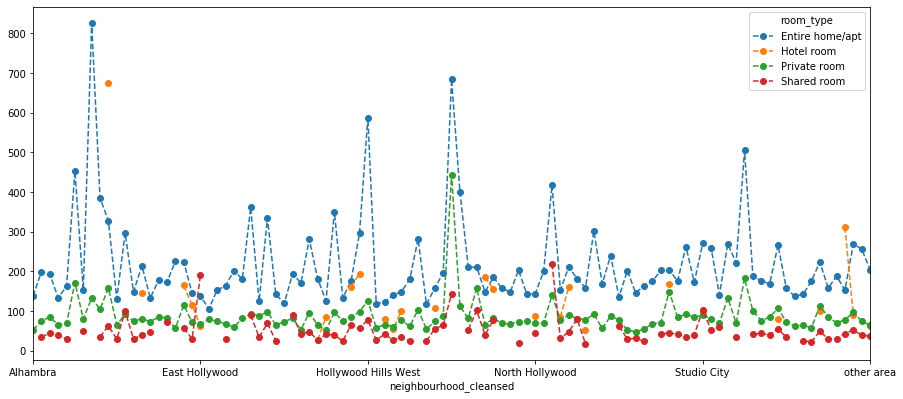

In [46]:
#price by neighbourhood averaged by room type
bynb=listing_201912.groupby(['neighbourhood_cleansed','room_type'])['price'].mean()
bynb.unstack().plot(marker='o', linestyle='--',figsize=(15,6.5))

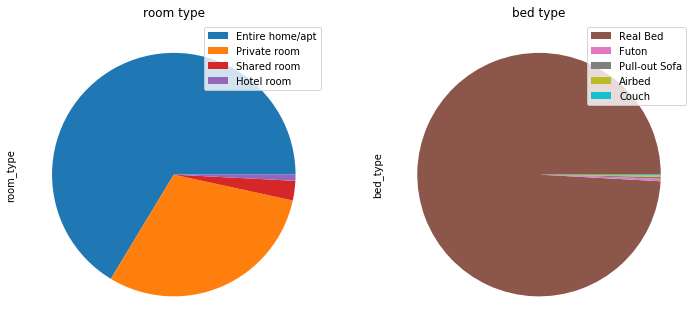

In [68]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); listing_201912.room_type.value_counts().plot(kind='pie',colors=['C0','C1','C3','C4'],labeldistance=None)
plt.title('room type')
plt.legend()
plt.subplot(1,2,2); listing_201912.bed_type.value_counts().plot(kind='pie',colors=['C5','C6','C7','C8','C9'],labeldistance=None)
plt.title('bed type')
plt.legend()

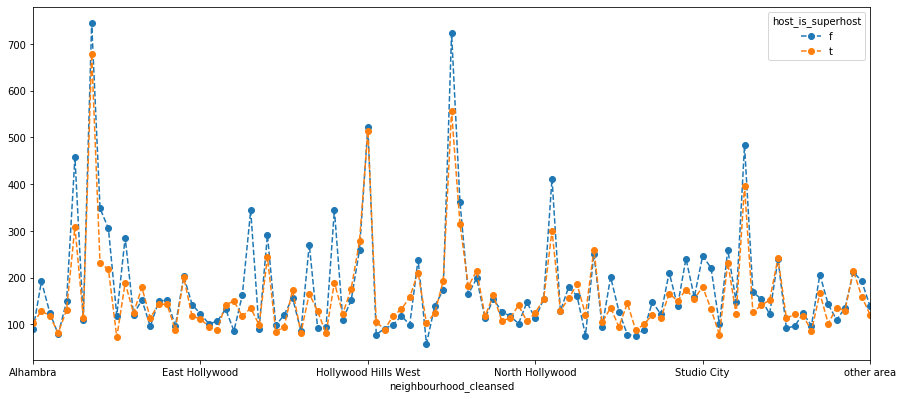

In [47]:
#superhost and price,for the same the location
bysh=listing_201912.groupby(['neighbourhood_cleansed','host_is_superhost'])['price'].mean()
bysh.unstack().plot(marker='o', linestyle='--',figsize=(15,6.5))

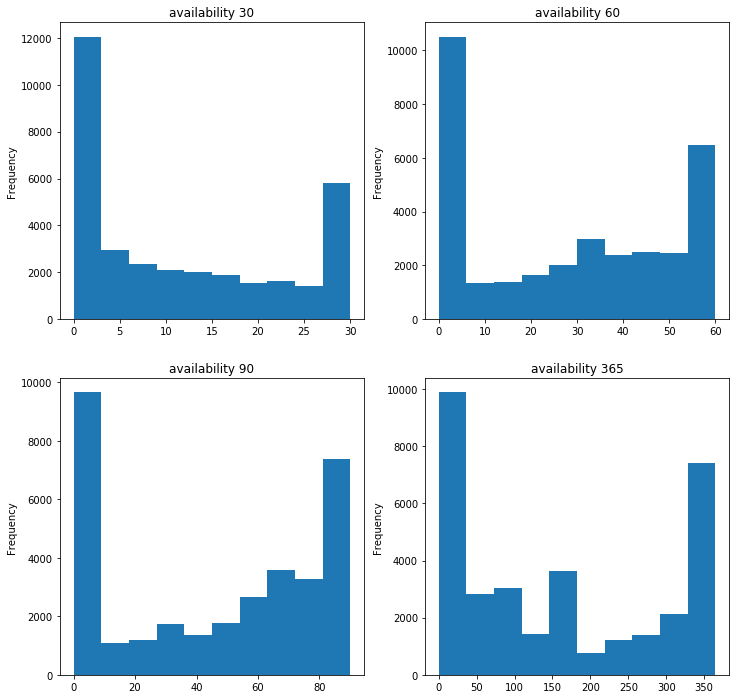

In [50]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plot_av1=listing_20191205.availability_30.plot(kind='hist')
plt.title('availability 30')
plt.subplot(2,2,2)
plot_av2=listing_20191205.availability_60.plot(kind='hist')
plt.title('availability 60')
plt.subplot(2,2,3)
plot_av3=listing_20191205.availability_90.plot(kind='hist')
plt.title('availability 90')
plt.subplot(2,2,4)
plot_av4=listing_20191205.availability_365.plot(kind='hist')
plt.title('availability 365')
plt.show()

Text(0, 0.5, 'Average Price ($)')

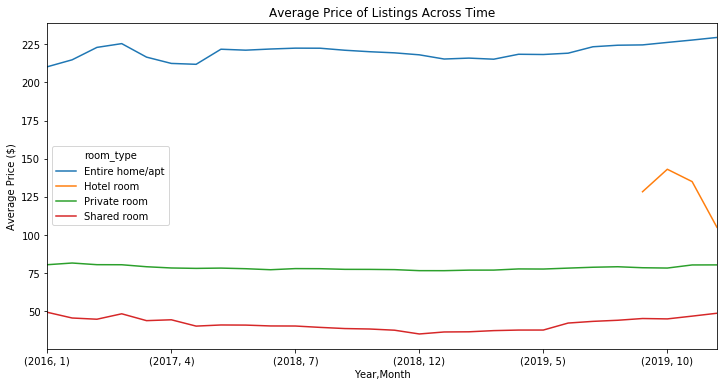

In [57]:
#time series trend of price, by neighbourhood
byym=df.groupby(['Year','Month','room_type'])['price'].mean()
byym.unstack().plot(figsize=(12,6))
plt.title('Average Price of Listings Across Time')
plt.ylabel('Average Price ($)')

Text(0.5, 1.0, 'Average Price of Listings For Different Months')

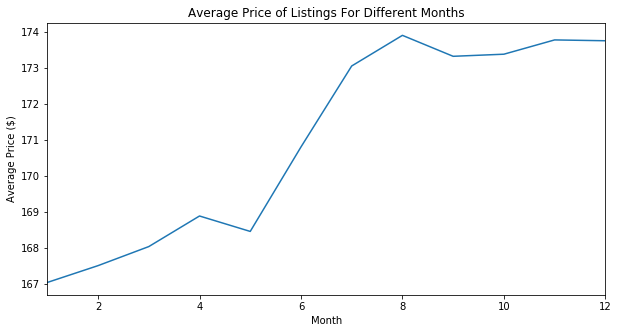

In [29]:
bym=df.groupby(['Month'])['price'].mean()
bym.plot(figsize=(10,5))
plt.ylabel('Average Price ($)')
plt.title('Average Price of Listings For Different Months')

In [30]:
bym

Month
1     167.036250
2     167.503797
3     168.033338
4     168.883620
5     168.454596
6     170.802225
7     173.053928
8     173.905500
9     173.323091
10    173.381494
11    173.778605
12    173.755496
Name: price, dtype: float64

## Inferential Statistics

In [374]:
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t

In [355]:
lm=sm.OLS(listing_20191205['price'],listing_20191205['bedrooms'])

In [356]:
result=lm.fit()

In [357]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.498
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                          3.940e+04
Date:                Sun, 09 Feb 2020   Prob (F-statistic):                        0.00
Time:                        20:23:11   Log-Likelihood:                     -2.7771e+05
No. Observations:               39784   AIC:                                  5.554e+05
Df Residuals:                   39783   BIC:                                  5.554e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms     143.3040      0.722    198.497      0.000     141.889     144.719
==============================================================================
Omnibus:                    46663.519   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5666757.943
Skew:                           6.248   Prob(JB):                         0.00
Kurtosis:                      60.117   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [358]:
lm2=sm.OLS(listing_20191205['price'],listing_20191205[amenities_columns])
result2=lm2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.309
Model:                            OLS   Adj. R-squared (uncentered):              0.309
Method:                 Least Squares   F-statistic:                              890.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):                        0.00
Time:                        20:23:33   Log-Likelihood:                     -2.8404e+05
No. Observations:               39784   AIC:                                  5.681e+05
Df Residuals:                   39764   BIC:                                  5.683e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Wifi                         85.9099      8.172     10.513      0.000      69.893     101.927
TV                           92.6804      4.268     21.714      0.000      84.315     101.046
Essentials                  -54.1283      7.610     -7.112      0.000     -69.045     -39.212
Smoke detector              -48.0577      6.855     -7.010      0.000     -61.494     -34.621
Heating                       1.1899      5.276      0.226      0.822      -9.150      11.530
Kitchen                      27.0492      5.085      5.319      0.000      17.082      37.017
Hangers                     -24.7446      5.391     -4.590      0.000     -35.311     -14.178
Shampoo                     -14.8202      4.603     -3.220      0.001     -23.842      -5.799
Carbon monoxide detector     12.9652      4.543      2.854      0.004       4.060      21.870
Air conditioning             24.2674      3.912      6.203      0.000      16.599      31.936
Hair dryer                    4.4679      4.792      0.932      0.351      -4.924      13.860
Washer                       16.6284     11.977      1.388      0.165      -6.847      40.104
Laptop friendly workspace     1.7683      4.042      0.437      0.662      -6.155       9.691
Dryer                        44.5728     11.861      3.758      0.000      21.325      67.821
Iron                         36.1002      4.388      8.228      0.000      27.501      44.700
Hot water                   -47.5962      3.879    -12.271      0.000     -55.198     -39.994
Free parking on premises     69.6567      3.267     21.320      0.000      63.253      76.060
Fire extinguisher            34.1436      3.293     10.370      0.000      27.690      40.597
Refrigerator                -22.4857      5.895     -3.815      0.000     -34.039     -10.932
Dishes and silverware        14.8780      5.899      2.522      0.012       3.316      26.440
==============================================================================
Omnibus:                    45965.524   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4608171.439
Skew:                           6.166   Prob(JB):                         0.00
Kurtosis:                      54.262   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [365]:
superhost=listing_20191205[listing_20191205.host_is_superhost=='t'].price
not_superhost=listing_20191205[listing_20191205.host_is_superhost=='f'].price


In [366]:
n0=len(superhost)
n1=len(not_superhost)
s0=np.std(superhost,ddof=1)
s1=np.std(not_superhost,ddof=1)
sp=np.sqrt(((n0-1)*s0**2+(n1-1)*s1**2)/(n0+n1-2))
sp

313.25412214394805

In [368]:
m0=np.mean(superhost)
m1=np.mean(not_superhost)
t_stat=(m0-m1)/(sp*np.sqrt(1/n0+1/n1))
t_stat

-7.960618191817725

In [372]:
p_value=t.cdf(t_stat, df=n0+n1-2, loc=0, scale=1)*2
print(p_value)

1.7569105964420412e-15


In [376]:
t, p_val = stats.ttest_ind(superhost, not_superhost, equal_var = True)
t, p_val

(-7.960618191817751, 1.7569105964416674e-15)